# Pluto V2
Trying cleaner data. Will split by each flow. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv

In [44]:
pcap_dfs = {}
with open(r'data\pluto\new-bidirectional\files.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader, None)
    for file_base, label in reader:
        pcap_dfs[file_base] = pd.read_csv(f"data\\pluto\\new-bidirectional\\{file_base}.csv")

In [45]:
pcap_dfs['AmazonPrime11']

,five-tuple,timestamp,packet_size,label
0,NaN,1.703400e+09,60,0
1,"192.168.1.7,239.255.255.250,51772,1900,UDP",1.703400e+09,217,0
2,NaN,1.703400e+09,60,0
3,"192.168.1.43,18.154.132.3,51465,443,TCP",1.703400e+09,880,0
4,"18.154.132.3,192.168.1.43,443,51465,TCP",1.703400e+09,2934,0
...,...,...,...,...
11735,"192.168.1.43,18.154.132.3,51466,443,TCP",1.703400e+09,54,0
11736,"192.168.1.43,18.154.132.3,51466,443,TCP",1.703400e+09,54,0
11737,"18.154.132.3,192.168.1.43,443,51466,TCP",1.703400e+09,2934,0
11738,"18.154.132.3,192.168.1.43,443,51466,TCP",1.703400e+09,2934,0


In [18]:
def seperate_flows(pcap_df):
    return dict(tuple(pcap_df.groupby('five-tuple')))

In [71]:
# get the max flow from each capture, calculate the inter arrival time
flow_dfs = {}
for pcap_key in pcap_dfs.keys():
    flows = seperate_flows(pcap_dfs[pcap_key])
    max_length_df_key = max(flows, key=lambda key: len(flows[key]))
    max_flow = flows[max_length_df_key].drop(columns=['label'])
    max_flow['iat'] = max_flow['timestamp'].diff().fillna(0)
    max_flow['timestamp'] = pd.to_datetime(max_flow['timestamp'], unit='s')
    flow_dfs[pcap_key] = max_flow

In [81]:
for k in flow_dfs.keys():
    print(k + " " + str(len(flow_dfs[k])) + " " + str((flow_dfs[k]['packet_size'] > 1500).sum()))

AmazonPrime11 4471 3047
AmazonPrime12 5741 3829
TeamsAudio10 5654 0
TeamsAudio11 7418 0
TeamsAudio12 5564 0
TeamsVideo10 27920 0
TeamsVideo11 30590 0
TeamsVideo12 24436 0
WhatsAppAudio10 2366 0
WhatsAppAudio11 1848 0
WhatsAppAudio12 1272 0
WhatsAppVideo10 47479 0
WhatsAppVideo11 29904 0
WhatsAppVideo12 30052 0
YouTubeLive10 5255 0
YouTubeLive11 5679 0
YouTubeLive12 10206 0
ZoomAudio10 8024 0
ZoomAudio11 5394 0
ZoomAudio12 7512 0
ZoomVideo10 27553 0
ZoomVideo11 27949 0
ZoomVideo12 24337 0


In [82]:
# Temporarily remove Amazon Prime because it contains many packets over the 1500 MTU
del flow_dfs['AmazonPrime11']
del flow_dfs['AmazonPrime12']

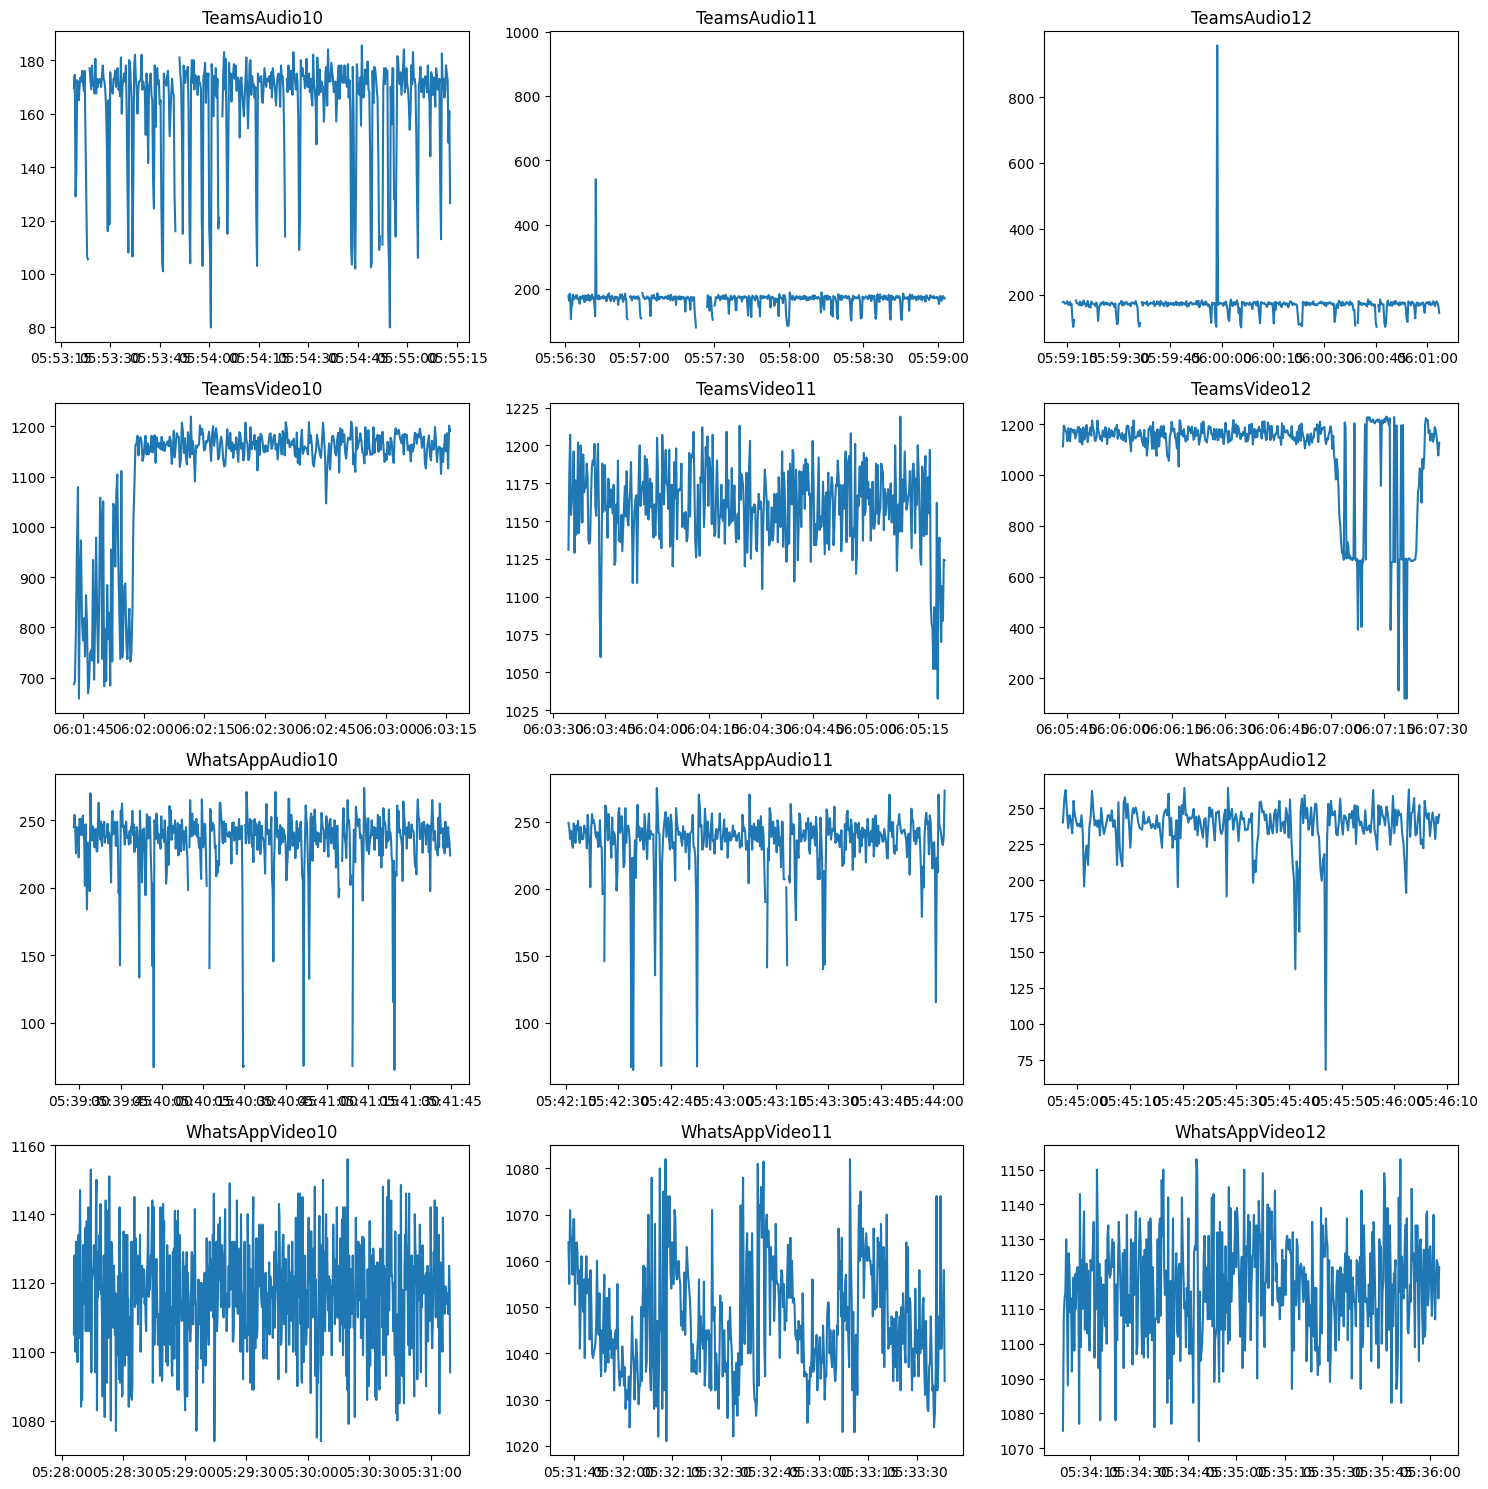

In [86]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

for i, flow_df_key in enumerate(list(flow_dfs.keys())[:12]):
    flow_df_test = flow_dfs[flow_df_key]
    filtered_cols = flow_df_test.drop(columns=['five-tuple', 'iat'])
    filtered_cols = filtered_cols.set_index('timestamp').resample('250L').median()

    row, col = divmod(i, 3)  # Calculate the row and column index
    axs[row, col].plot(filtered_cols.index, filtered_cols['packet_size'])
    axs[row, col].set_title(flow_df_key)

plt.tight_layout()
plt.show()

Creating features for these flows

In [87]:
def create_features(flow_df):
    def custom_analysis(chunk):
        first_50 = chunk[chunk.index.microsecond < 50000]
        result = {
            'num_packets': len(chunk),
            'agg_size': chunk['packet_size'].sum(),
            'max_size': chunk['packet_size'].max(),
            'med_size': chunk['packet_size'].median(),
            'mean_size': chunk['packet_size'].mean(),
            'min_iat' : chunk['iat'].min(),
            'mean_iat': chunk['iat'].mean(),
            'med_iat': chunk['iat'].median(),
    
            'f50_num_packets': len(first_50),
            'f50_agg_size': first_50['packet_size'].sum(),
            'f50_max_size': first_50['packet_size'].max(),
            'f50_med_size': first_50['packet_size'].median(),
            'f50_mean_size': first_50['packet_size'].mean(),
            'f50_min_iat': first_50['iat'].min(),
            'f50_mean_iat': first_50['iat'].mean(),
            'f50_med_iat': first_50['iat'].median()
        }
        #raise Error("hi")
        return pd.Series(result)
        
    flow_df['timestamp'] = pd.to_datetime(flow_df['timestamp'], unit='s')
    flow_features = flow_df.set_index('timestamp').resample('1s').apply(custom_analysis).fillna(0)
    return flow_features

In [90]:
create_features(flow_dfs['TeamsAudio10']).reset_index(inplace=True)

In [93]:
features = create_features(flow_dfs['TeamsAudio10'])
features.reset_index(inplace=True)

In [95]:
features_df ={}
for flow_df_key in flow_dfs.keys():
    features = create_features(flow_dfs[flow_df_key]).reset_index(drop=True)
    features_df[flow_df_key] = features

In [104]:
for flow_df_key in features_df.keys():
    features_df[flow_df_key]['capture'] = flow_df_key

Trying PCA

In [133]:
column_map = {
    "AmazonPrime10": "Amazon Prime",
    "AmazonPrime11": "Amazon Prime",
    "AmazonPrime12": "Amazon Prime",
    "TeamsAudio10": "Teams Audio",
    "TeamsAudio11": "Teams Audio",
    "TeamsAudio12": "Teams Audio",
    "TeamsVideo10": "Teams Video",
    "TeamsVideo11": "Teams Video",
    "TeamsVideo12": "Teams Video",
    "WhatsAppAudio10": "WhatsApp Audio",
    "WhatsAppAudio11": "WhatsApp Audio",
    "WhatsAppAudio12": "WhatsApp Audio",
    "WhatsAppVideo10": "WhatsApp Video",
    "WhatsAppVideo11": "WhatsApp Video",
    "WhatsAppVideo12": "WhatsApp Video",
    "YouTubeLive10": "Youtube Live",
    "YouTubeLive11": "Youtube Live",
    "YouTubeLive12": "Youtube Live",
    "ZoomAudio10": "Zoom Audio",
    "ZoomAudio11": "Zoom Audio",
    "ZoomAudio12": "Zoom Audio",
    "ZoomVideo10": "Zoom Video",
    "ZoomVideo11": "Zoom Video",
    "ZoomVideo12": "Zoom Video",
}

In [113]:
from sklearn.decomposition import PCA

X = pd.concat(features_df.values()).drop(columns=['capture']).reset_index(drop=True)
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [134]:
print(pca.explained_variance_ratio_)
transformed = pca.transform(X)
pca_df = pd.DataFrame(data=transformed, columns=['PC1', 'PC2'])
pca_df['capture'] = pd.concat(features_df.values()).reset_index(drop=True)['capture'].map(column_map)

[0.99871517 0.00127123]


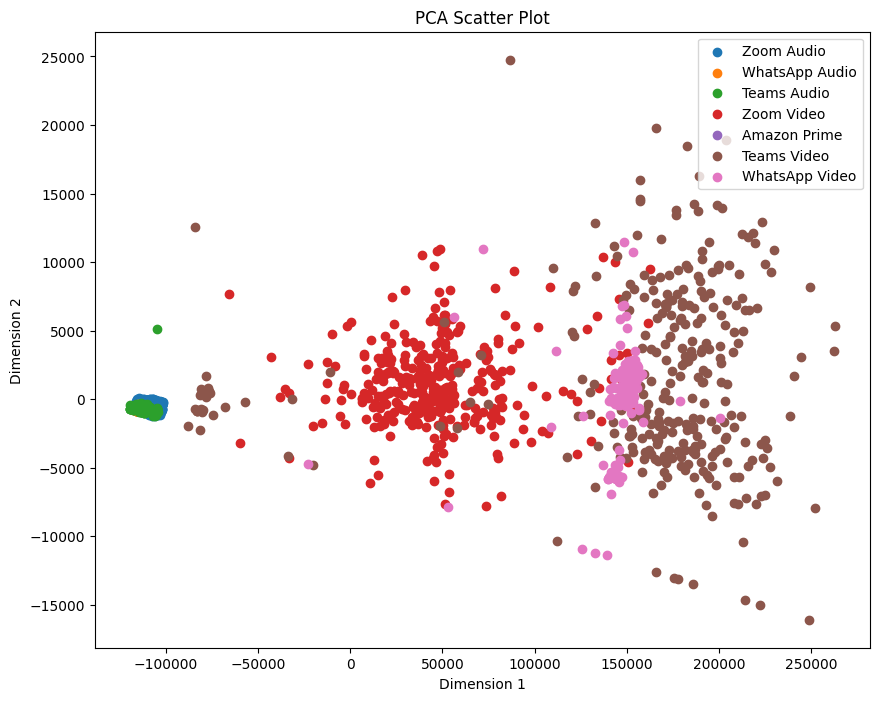

In [139]:
plt.figure(figsize=(10, 8))
column_vals = set(column_map.values())
for column in column_vals:
    if "Youtube" in column:
        continue
    pca_df_cat = pca_df[pca_df['capture'] == column]
    plt.scatter(pca_df_cat['PC1'], pca_df_cat['PC2'], label=column)
plt.title('PCA Scatter Plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(loc="upper right")

Random Forest

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X = pd.concat(features_df.values()).drop(columns=['capture'])
Y = pd.concat(features_df.values())['capture'].map(column_map)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

rf_clf = RandomForestClassifier(max_depth=7, random_state=0, criterion='entropy',n_estimators=100)
rf_clf.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', max_depth=7, random_state=0)

In [148]:
y_train_pred = rf_clf.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_train_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


In [149]:
X_test_scaled = scaler.transform(X_test)
y_test_pred = rf_clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.99


In [300]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_test_pred, labels=['Zoom Audio', 'Zoom Video', 'Teams Audio', 'Teams Video', 'WhatsApp Audio', 'WhatsApp Video', 'Youtube Live'])
conf_matrix

array([[83,  0,  4,  0,  0,  0,  0],
       [ 0, 66,  0,  0,  0,  0,  0],
       [ 1,  0, 69,  1,  0,  0,  0],
       [ 0,  0,  0, 68,  0,  0,  0],
       [ 0,  0,  0,  0, 60,  0,  0],
       [ 0,  0,  0,  0,  0, 88,  0],
       [ 0,  0,  0,  0,  0,  0, 54]], dtype=int64)

([<matplotlib.axis.YTick at 0x1d08e736590>,
 [Text(0, 0, 'Zoom Audio'),
  Text(0, 1, 'Zoom Video'),
  Text(0, 2, 'Teams Audio'),
  Text(0, 3, 'Teams Video'),
  Text(0, 4, 'WhatsApp Audio'),
  Text(0, 5, 'WhatsApp Video'),
  Text(0, 6, 'Youtube Live')])

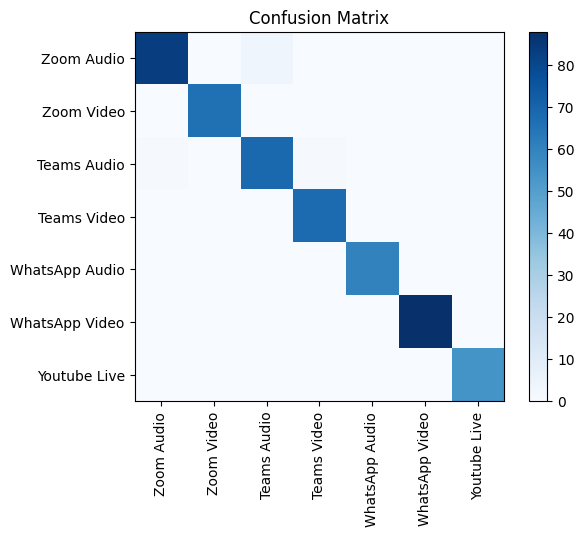

In [301]:
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Zoom Audio', 'Zoom Video', 'Teams Audio', 'Teams Video', 'WhatsApp Audio', 'WhatsApp Video', 'Youtube Live']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

Testing with Mirage

In [246]:
teams_test_df = pd.read_csv(r"data\teams_data\3.csv")

In [220]:
flows = seperate_flows(teams_test_df)
max_length_df_key = max(flows, key=lambda key: len(flows[key]))
max_flow = flows[max_length_df_key]

In [221]:
mirage_features = create_features(max_flow).reset_index(drop=True)

In [222]:
X_mirage = scaler.transform(mirage_features)
y_mirage = rf_clf.predict(X_mirage)

In [223]:
((y_mirage == 'Teams Video') | (y_mirage == 'Teams Audio')).sum() / len(y_mirage)

0.8873202614379085

In [287]:
import os

directory_path = r'data\zoom_data'
teams_files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
accuracies = []
for file in teams_files[:]:
    teams_test_df = pd.read_csv(os.path.join(directory_path, file))
    flows = seperate_flows(teams_test_df)
    max_length_df_key = max(flows, key=lambda key: len(flows[key]))
    max_flow = flows[max_length_df_key]
    mirage_features = create_features(max_flow).reset_index(drop=True)
    X_mirage = scaler.transform(mirage_features)
    y_mirage = rf_clf.predict(X_mirage)
    accuracy = ((y_mirage == 'Zoom Video') | (y_mirage == 'Zoom Audio')).sum() / len(y_mirage)
    accuracies.append(accuracy)

Text(0, 0.5, 'Count')

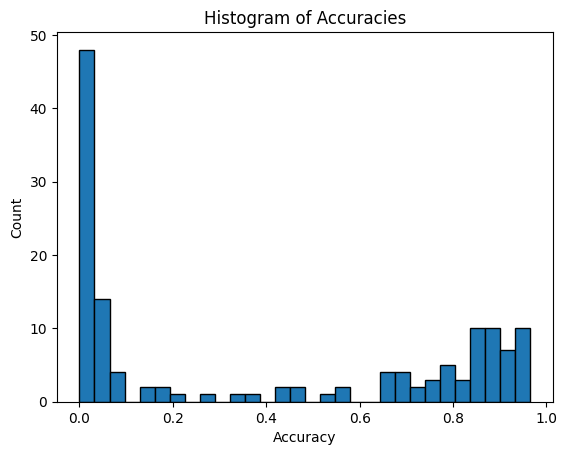

In [290]:
plt.hist(accuracies, bins=30, edgecolor='black')
plt.title('Histogram of Accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Count')

Trying with old zoom profile

In [285]:
old_pluto_test = pd.read_csv(r'data\pluto\old-bidirectional\teams-audio1.csv')
flows = seperate_flows(old_pluto_test)
max_length_df_key = max(flows, key=lambda key: len(flows[key]))
max_flow = flows[max_length_df_key]
max_flow['iat'] = max_flow['timestamp'].diff().fillna(0)
mirage_features = create_features(max_flow).reset_index(drop=True)
X_mirage = scaler.transform(mirage_features)
y_mirage = rf_clf.predict(X_mirage)
((y_mirage == 'WhatsApp Audio') | (y_mirage == 'Teams Audio') | (y_mirage == 'Zoom Audio')).sum() / len(y_mirage)

1.0

In [286]:
y_mirage

array(['Teams Audio', 'Teams Audio', 'Teams Audio', 'Teams Audio',
       'Teams Audio', 'Teams Audio', 'Teams Audio', 'Teams Audio',
       'Teams Audio', 'Teams Audio', 'Teams Audio', 'Teams Audio',
       'Teams Audio', 'Teams Audio', 'Teams Audio', 'Teams Audio',
       'Teams Audio', 'Teams Audio', 'Teams Audio', 'Teams Audio',
       'Teams Audio', 'Teams Audio', 'Teams Audio', 'Teams Audio',
       'Teams Audio', 'Teams Audio', 'Teams Audio', 'Teams Audio',
       'Teams Audio', 'Teams Audio', 'Teams Audio', 'Teams Audio',
       'Teams Audio', 'Teams Audio', 'Teams Audio', 'Teams Audio',
       'Teams Audio', 'Teams Audio', 'Teams Audio', 'Teams Audio',
       'Teams Audio', 'Teams Audio', 'Teams Audio', 'Teams Audio',
       'Teams Audio', 'Teams Audio', 'Teams Audio', 'Teams Audio',
       'Teams Audio', 'Teams Audio', 'Teams Audio', 'Teams Audio',
       'Teams Audio', 'Teams Audio', 'Teams Audio', 'Teams Audio',
       'Teams Audio', 'Teams Audio', 'Teams Audio', 'Teams Aud